In [2]:
import os, sys
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

import pandas as pd
from utils import train_fairness_classifiers
from src.analyze_metric_sensitivity import analyze_metric_bias_sensitivity
from src.data_utils import joint_distribution

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [4]:
ds = np.load("../data/adult_new.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]
perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [5]:
disparity_metrics = ["FPR", "FNR", "PPP", "NPP"]
prob_dfs = {}
for disparity_metric in disparity_metrics:
    classifiers = train_fairness_classifiers(X_train, y_train, A_train, disparity_metric=disparity_metric)
    df = pd.DataFrame({
        "A": A_test, "Y": y_test, "P": classifiers[0].predict(X_test)
    })
    prob_df = joint_distribution(df, ["A", "Y", "P"])
    prob_dfs[disparity_metric] = prob_df

/Users/njwfish/fragile.ml/.conda/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/njwfish/fragile.ml/.conda/lib/python3.11

In [12]:
# note that starting at 0 here will throw an error so you need to compute 
# the values with the params at zero using a different loop
sens_param_range = np.linspace(0.01, 0.05, 5)
results = {
    disparity_metric: {"Proxy Y": [], "Selection": [], "Proxy Y and Selection": []}
    for disparity_metric in disparity_metrics
}

for disparity_metric in disparity_metrics:
    for i, sens_param in enumerate(sens_param_range):
        selection_results = analyze_metric_bias_sensitivity(
            prob_dfs[disparity_metric], disparity_metric, "selection",
            sensitivity_parameter_values=sens_param,
        )
        results[disparity_metric]["Selection"].append(selection_results)

        proxy_y_results = analyze_metric_bias_sensitivity(
            prob_dfs[disparity_metric], disparity_metric, "proxy_y",
            sensitivity_parameter_values=sens_param,
        )
        results[disparity_metric]["Proxy Y"].append(proxy_y_results)

        proxy_y_selection_results = analyze_metric_bias_sensitivity(
            prob_dfs[disparity_metric], disparity_metric, "proxy_y_and_selection",
            sensitivity_parameter_values=sens_param,
        )
        results[disparity_metric]["Proxy Y and Selection"].append(proxy_y_selection_results)
        print(disparity_metric, i)



FPR 0
FPR 1
FPR 2
FPR 3
FPR 4
FNR 0
FNR 1
FNR 2
FNR 3
FNR 4
PPP 0
PPP 1
PPP 2
PPP 3
PPP 4
NPP 0
NPP 1
NPP 2
NPP 3
NPP 4


In [27]:
# add selection + proxy_y
for disparity_metric in disparity_metrics:
    results[disparity_metric]["Selection + Proxy Y"] = [
        (s[0] + y[0], s[1] + y[1]) for s, y in zip(results[disparity_metric]["Selection"], results[disparity_metric]["Proxy Y"])
    ]

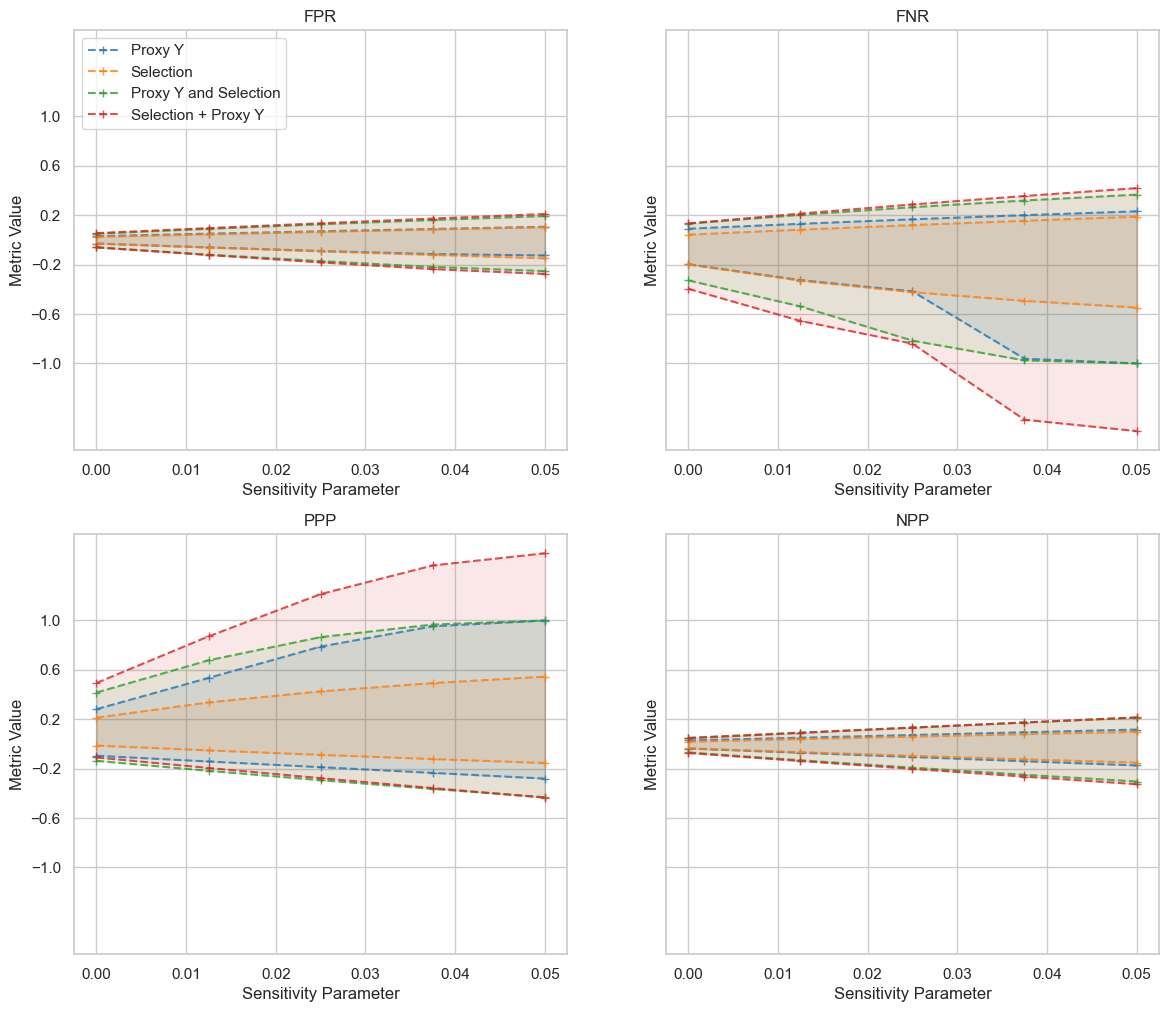

In [29]:
fig, ax = plt.subplots(nrows=2,ncols=2,sharey=True,figsize= (14, 12))
ax = ax.reshape(4)

range_ab = np.linspace(0,0.05,5)
colours = sns.color_palette("tab10", 4)

legend_labels = list(results["FPR"].keys())

lines = []
for i, metric in enumerate(disparity_metrics):

    # metric_val = results[1][0][0]
    # result_list_plus = [(max(x[0]+y[0]-metric_val,-1),min(x[1]+y[1]-metric_val,1)) for x,y in zip(results[1],results[2])]
    # results.append(result_list_plus)
    lines = []
    for j, label in enumerate(results[metric]):
        lower_results = []
        upper_results = []
        for val in results[metric][label]:
            lower_results.append(val[0])
            upper_results.append(val[1])
        ax[i].fill_between(range_ab, lower_results, upper_results, alpha=.1,color = colours[j])
        line,  = ax[i].plot(range_ab, upper_results, ls='--', marker='+', alpha=0.8,color=colours[j])
        ax[i].plot(range_ab, lower_results, ls='--',marker='+', alpha=0.8,color=colours[j])
        lines.append(line)
        ax[i].set_yticks(np.arange(-1, 1.2, 0.4))
        ax[i].set_xlabel("Sensitivity Parameter")
        ax[i].set_ylabel("Metric Value")
        ax[i].set_title(metric)


ax[0].legend(handles = lines,labels = results[metric], loc = "upper left")